In [179]:
# importing packages

import numpy as np
import scipy.stats as stats
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [186]:
# Simulate Data
HERITABILITY = 0.85
p = 0.05
INDIVIDUALS = 300
MARKERS = 1000

# x in {0,1,2}
X = np.random.randint(0,3, size=(INDIVIDUALS,MARKERS))

# each marker has a p chance of have a normally distributed effect
# with variance 1
effect = np.random.normal(0, 1, size=(MARKERS))
for i in range(len(effect)):
    if np.random.random() > p:
        effect[i] = 0
noise = np.random.normal(0, 1 - HERITABILITY, size=(INDIVIDUALS))

# generate phenotypes
y = (X).dot(effect) + noise

In [187]:
def compute_beta_value(X_i, y):
    # solves linear regression 
    return 1/(np.dot(X_i, X_i)) * np.dot(X_i, y-np.mean(y))

# solve linear equation for each beta
betas = np.array([compute_beta_value(x_i, y) for x_i in X.T])

Text(0, 0.5, 'beta')

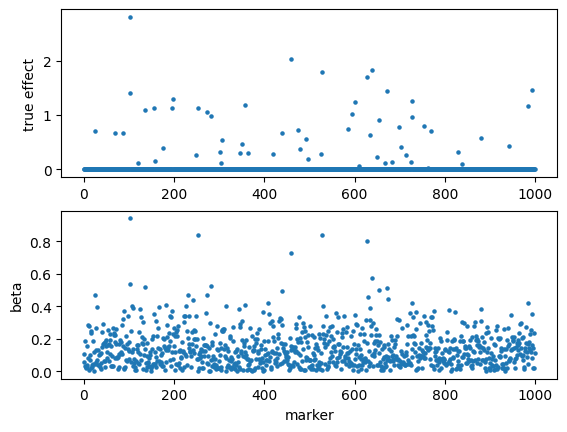

In [192]:
# Figure of betas and true phenotypes

fig, axs = plt.subplots(2,1)

axs[0].scatter(np.arange(MARKERS), np.abs(effect), s=5)
axs[1].scatter(np.arange(MARKERS), np.abs(betas), s=5)

axs[1].set_xlabel("marker")
axs[0].set_ylabel("true effect")
axs[1].set_ylabel("beta")

In [189]:
# now find p values 
critical = 0.95
p_wald = critical/MARKERS

beta_mean = sum(betas)/len(betas)
beta_variance = sum([(betas[i] - beta_mean)**2 for i in range(MARKERS)])/len(betas)

betas_normalised = (np.array([(betas[i]-beta_mean)/beta_variance for i in range(MARKERS)]))

p_values = -np.log(np.array([stats.norm.pdf(beta) for beta in betas_normalised]))


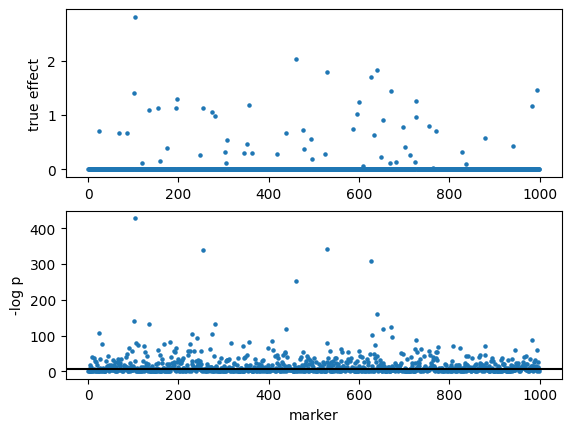

In [191]:
fig, axs = plt.subplots(2,1)

axs[0].scatter(np.arange(MARKERS), np.abs(effect), s=5)
axs[1].scatter(np.arange(MARKERS), np.abs(p_values), s=5)

axs[1].set_xlabel("marker")
axs[0].set_ylabel("true effect")
axs[1].set_ylabel("-log p")

axs[1].axhline(y=-np.log(p_wald), color='black', linestyle='-')
